In [71]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import anndata

import torch
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE
import scipy.io as sio
from scipy.sparse import coo_matrix
import os
from umap import UMAP

PRJ_DIR = "/home/derek/research/Kim-Lab/normalization-simulation/"
IN_DIR = PRJ_DIR + "data/pbmc-33k/filtered_gene_bc_matrices/hg19/"
OUT_DIR = PRJ_DIR + "exp/exp-12/out/"

In [72]:
cell_type_list = ["CD4_Memory", "CD4_Naive", "Mono_CD14", "B_Pre",
                  "CD8_Memory", "CD8_Naive", "NK_Dim", "Mono_CD16",
                  "CD8_Effector", "B_Pro", "DC", "NK_Bright", "Mk", "pDC"]
cell_type_idx = -2

In [73]:
file_prefix = cell_type_list[cell_type_idx]
print(f'working on {file_prefix}')
file_name = OUT_DIR + file_prefix + '-cm.mm'
counts_sparse = sio.mmread(file_name)
counts = counts_sparse.toarray().astype('float64')

file_name = OUT_DIR + file_prefix + '-ident.csv'
batch_list = pd.read_csv(file_name)

working on CD8_Naive


In [74]:
from scvi.dataset import AnnDatasetFromAnnData
adata = anndata.AnnData(X=counts.T)
adata.obs['group'] = batch_list['x'].to_numpy()

adata.obs['group'] = adata.obs['group'].replace({'group1': 0, 'group2': 1})
adata.obs['group'] = adata.obs['group'].astype(int)
sc.pp.filter_genes(adata, min_cells=5)

In [75]:
cm = AnnDatasetFromAnnData(adata)
cm

[2020-07-11 01:21:02,195] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-11 01:21:02,196] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-11 01:21:02,427] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-11 01:21:02,453] INFO - scvi.dataset.dataset | Downsampled from 1917 to 1917 cells


GeneExpressionDataset object with n_cells x nb_genes = 1917 x 10356
    gene_attribute_names: 'n_cells', 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_vars', 'group', 'labels', 'local_means'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [76]:
n_epochs = 400
n_de = 4000

In [77]:
cm.subsample_genes(n_de)

[2020-07-11 01:21:02,469] INFO - scvi.dataset.dataset | extracting highly variable genes using seurat_v3 flavor


Transforming to str index.


[2020-07-11 01:21:02,769] INFO - scvi.dataset.dataset | Downsampling from 10356 to 4000 genes
[2020-07-11 01:21:02,870] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-11 01:21:02,889] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-07-11 01:21:02,988] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-11 01:21:02,995] INFO - scvi.dataset.dataset | Downsampled from 1917 to 1917 cells


In [78]:
use_cuda = True

vae = VAE(cm.nb_genes, n_batch=0, n_labels=0,
          n_hidden=128, n_layers=1, n_latent=10, dispersion='gene')

trainer = UnsupervisedTrainer(
    vae, cm,
    train_size=1.0,
    batch_size=128,
    use_cuda=use_cuda,
    n_epochs_kl_warmup=100,
    frequency=10
)

In [79]:
%%time
trainer.train(n_epochs=n_epochs)

[2020-07-11 01:21:03,132] INFO - scvi.inference.inference | KL warmup for 100 epochs



CPU times: user 13min 22s, sys: 9.27 s, total: 13min 31s
Wall time: 1min 41s


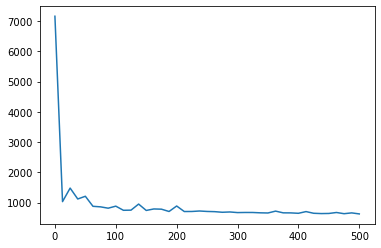

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
elbo_train_set = trainer.history["elbo_train_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
# plt.ylim(1150, 1600)

In [81]:
full = trainer.create_posterior(trainer.model,
                                cm, indices=np.arange(len(cm)))

In [82]:
idx1 = adata.obs['group'] == 0
idx2 = adata.obs['group'] == 1
n_samples = 100
M_permutation = 100000

n_de = 0
for i in range(30):
    marker = full.differential_expression_score(idx1, idx2,
                                                n_samples=n_samples,
                                                M_permutation=M_permutation)
    n_de = n_de + np.sum(np.logical_or(marker['bayes_factor'] > 2.3,
                                       marker['bayes_factor'] < -2.3))

res = int(n_de/30) if (n_de % 30 < 0.5) else int(n_de/30) + 1
res

17

In [83]:
file_name = OUT_DIR + '8-' + file_prefix + "-full_posterior"
if not os.path.isfile(file_name):
    print(f'writing to {file_name}...')
    full.save_posterior(file_name)

file_name = OUT_DIR + '8-' + file_prefix + "-marker.csv"
if not os.path.isfile(file_name):
    print(f'writing to {file_name}...')
    marker.to_csv(file_name)

Transforming to str index.
... storing 'cell_types' as categorical


writing to /home/derek/research/Kim-Lab/normalization-simulation/exp/exp-12/out/8-CD8_Naive-full_posterior...
writing to /home/derek/research/Kim-Lab/normalization-simulation/exp/exp-12/out/8-CD8_Naive-marker.csv...


/home/derek/miniconda3/envs/py-ds-scanpy-2/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  pytables.to_hdf(


In [84]:
# # loading step (in a new session)
# retrieved_model = VAE(gene_dataset.nb_genes)  # uninitialized model
# save_dir = os.path.join(save_path, "full_posterior")

# retrieved_full = load_posterior(
#     dir_path=save_dir,
#     model=retrieved_model,
#     use_cuda=use_cuda,
# )